In [ ]:
# Copyright (C) 2024  Jose Ángel Pérez Garrido
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Part-of-speech (PoS) Tagging

**Goal**: implement a neural PoS sequence labeling model to label the words of a given input sentence according to their morphological information.

**USAGE GUIDELINES**

This program support the following functionalities. To use them move to the desired section and follow the instructions:
1. (Section 1) Train a model and save it as a pickle file.
2. (Section 2) Evaluate a previously trained model and provide tagging accuracy metrics.
3. (Section 3) Compute part-of-speech tags for newly inputted sentences by the user that have not been seen before.


**NOTE: First, make sure you configure and execute the following cells in order to setup the working environment.**


In [1]:
# SET VARIABLES
# @title Setup working environment
# @markdown ### General configuration
workspace_folder = "/content/drive/MyDrive/src" # @param {type:"string"}
# @markdown workspace_folder = Directory which contains the application .py files (fileparser.py, preprocess.py, posmodel.py)
# @markdown - Note: You should set the absolute path where you have saved the required modules, taking into account that, in *Google Colaboratory*, you have direct access to the folder `/content/`

In [2]:
# Prepare the environment

# Mount drive folder
from google.colab import drive
drive.mount('/content/drive')

# Uninstall the current version of TensorFlow.
#!pip uninstall tensorflow -2.13.0

# Install TensorFlow 2.12.0.
#!pip install tensorflow==2.12.0

# Install required libraries
!pip install conllu==4.5.3
!pip install pydot==1.4.2
!pip install pyparsing==3.1.1
!pip install tqdm==4.66.1

import os, sys, pickle
import matplotlib.pyplot as plt

# Verify the TensorFlow version.
import tensorflow as tf
from tensorflow.python import keras
print(tf.__version__)

Mounted at /content/drive
2.14.0


In [3]:
# Import P1 developed Python classes
sys.path.append(workspace_folder)

from P1.preprocess import *
from P1.posmodel import *
from P1.fileparser import *

**Data preparation**

Download the dataset (`conllu` files) from the *GitHub* of Universal Dependencies (UD). We use the utility function [`tensorflow.keras.utils.get_file()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) to download the files.

In [4]:
# Load the datasets

# Set the datasets location folder
datafolder = "/content/Datasources"

# Create folders to save treebanks
languages = ["UD_English-EWT", "UD_English-GUM", "UD_Russian-SynTagRus", "UD_Russian-Taiga", "UD_Spanish-AnCora", "UD_Spanish-GSD"]
for i in languages:
  if not os.path.exists(datafolder+"/"+i):
    os.makedirs(datafolder+"/"+i)

# Download Treebanks
#◘UD_English-EWT
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_English-EWT/dev.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_English-EWT/test.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_English-EWT/train.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu",
    extract=False
)

#◘UD_English-GUM
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_English-GUM/dev.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-dev.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_English-GUM/test.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-test.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_English-GUM/train.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu",
    extract=False
)

# UD_Russian-SynTagRus
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Russian-SynTagRus/dev.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Russian-SynTagRus/test.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Russian-SynTagRus/train.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu",
    extract=False
)

# UD_Russian-Taiga
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Russian-Taiga/dev.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-Taiga/master/ru_taiga-ud-dev.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Russian-Taiga/test.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-Taiga/master/ru_taiga-ud-test.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Russian-Taiga/train.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-Taiga/master/ru_taiga-ud-train.conllu",
    extract=False
)

#UD_Spanish-AnCora
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Spanish-AnCora/dev.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/master/es_ancora-ud-dev.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Spanish-AnCora/test.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/master/es_ancora-ud-test.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Spanish-AnCora/train.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/master/es_ancora-ud-train.conllu",
    extract=False
)

#UD_Spanish-GSD
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Spanish-GSD/dev.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-dev.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Spanish-GSD/test.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-test.conllu",
    extract=False
)
tf.keras.utils.get_file(
    fname=str(f"{datafolder}/UD_Spanish-GSD/train.conllu"),
    origin="https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-train.conllu",
    extract=False
)

23295127/23295127 [==============================] - 0s 0us/step


'/content/Datasources/UD_Spanish-GSD/train.conllu'

////////////////////////////////////////////////////////////////////////////////////////////////////////

# 1. TRAIN A MODEL

**(Requirements) Setup the training module:**

First of all, you must configure the variables in the following cell to execute the program. Then, you can start the following cells to train the model. An explanation of the different variables is provided below:

---
### Dataset configuration
*   language = The treebank dataset to be selected
---
### Model topology
*   lstm_units = Units for the bidirectional LSTM layer
*   num_dense = Number of hidden TimeDistributed Dense layers
*   dense_units = Units for every hidden TimeDistributed Dense layers
---
### Model hyperparameters
*   optimizer = Algorithm that will adjust the model's parameters during training to minimize the loss function
* epochs = Number of times the training data passes through the algorithm
* batch_size = Number of samples that will be propagated through the network

We will use the loss function "sparse_categorical_crossentropy" and the metric "accuracy".





In [5]:
# SET VARIABLES
# @title Training module configuration. Set the following variables
# @markdown ### Dataset configuration
language = "UD_English-EWT" # @param ["UD_English-EWT","UD_Russian-SynTagRus","UD_Spanish-AnCora"]

# @markdown ---
# @markdown ### Model topology
lstm_units = 48 # @param {type:"number", min:1, max:512, step:1}
num_dense = 0 # @param @param {type:"number", min:1, max:20, step:1}
dense_units = 0 # @param {type:"number", min:1, max:512, step:1}

# @markdown ---
# @markdown ### Model hyperparameters
optimizer = "adam" # @param ["adam", "sgd", "rmsprop", "adadelta", "adagrad", "adamax", "adafactor", "nadam", "ftrl"]
epochs = 4 # @param {type:"slider", min:1, max:100, step:1}
batch_size = 64 # @param {type:"number", min:1, max:512, step:1}

hyperparameters = {
    "loss" : "sparse_categorical_crossentropy",
    "optimizer" : optimizer,
    "metrics" : ["accuracy"],
    "epochs" : epochs,
    "batch_size" : batch_size
}

# Set topology
topology ={
    "lstm_units" : int(lstm_units),
    "num_dense" : int(num_dense),
    "dense_units" : int(dense_units)
}

**2. Process the treebank**

Secondly, we preprocess the treebank dataset. This whole process will return the data structured in two lists:
- A list consisted of input sentences
- A list of labels containing the correspondent POS tag for each word in the input sentence

We make use of the class `Conllu_parser()` available in the file `preprocess.py` to extract the data (tokens FORM and UPOS) from the different .conllu files for training, validation and test. In addition, this class ignore sentences longer than 128 and makes sure to remove empty tokens and multi-word units.

In [6]:
# PREPROCESS INPUT SAMPLES
print("Loading",language,"dataset", end="")

parser = Conllu_parser()

# Parse train file
input_str = str(f"{datafolder}/{language}/train.conllu")
x_train, y_train = parser(input_str)

# Parse validation file
input_str = str(f"{datafolder}/{language}/dev.conllu")
x_val, y_val=parser(input_str)

# Parse test file
input_str = str(f"{datafolder}/{language}/test.conllu")
x_test, y_test=parser(input_str)

Loading UD_English-EWT datasetDataset loaded in memory.
e.g. sentence number 10: TokenList<Al, -, Zaman, :, Guerrillas, killed, a, member, of, the, Kurdistan, Democratic, Party, after, kidnapping, him, in, Mosul, ., metadata={sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0011", text: "Al-Zaman : Guerrillas killed a member of the Kurdistan Democratic Party after kidnapping him in Mosul."}>
Dataset loaded in memory.
e.g. sentence number 10: TokenList<In, the, eastern, city, of, Baqubah, ,, guerrillas, detonated, a, car, bomb, outside, a, police, station, ,, killing, several, people, ., metadata={newdoc id: "weblog-juancole.com_juancole_20040114085100_ENG_20040114_085100", sent_id: "weblog-juancole.com_juancole_20040114085100_ENG_20040114_085100-0001", newpar id: "weblog-juancole.com_juancole_20040114085100_ENG_20040114_085100-p0001", text: "In the eastern city of Baqubah, guerrillas detonated a car bomb outside a police station, killing several people."}>
Data

Then we create a label dictionary which will allow us to make an ad-hoc mapping to ids of the target sets. We only use the train targets to guarantee we are testing correctly the generalization capabilities of our model.

In [7]:
# Generate a label dict
print("Generating label dict", end="")
target_label_dict = generate_label_dict(y_train)
print(" - DONE")

Generating label dict - DONE


To end with, with apply a preprocessing function in both the target sets to convert them to labels and apply a padding function.

In [8]:
# Preprocess datasets
print("Preprocessing data", end="")
x_train, y_train = preprocess(x_train, y_train, target_label_dict)
x_val, y_val = preprocess(x_val, y_val, target_label_dict)
x_test, y_test = preprocess(x_test, y_test, target_label_dict)
print(" - DONE")

Preprocessing data - DONE


**3. Train a POS tagger model**

Now we create the architecture, compile and train the model. At the end of the training phase, we make an evaluation of the generalization capabilities of the model using the test set.

In [9]:
# Create POS model architecture
print("Creating model")
model = PosModel(target_label_dict)
model.build_model(x_train, topology)

# Train
print("TRAINING")
history = model.train((x_train,y_train),(x_val,y_val),hyperparameters)

# Evaluate
print("EVALUATING")
print("[Eval_Loss, Eval_Accuracy] =",model.evaluate((x_test, y_test), hyperparameters["batch_size"]))
print("DONE")

Creating model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 128, 48)           943488    
                                                                 
 bidirectional (Bidirection  (None, 128, 96)           37248     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 128, 18)           1746      
 ributed)                                                        
                                              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/4
196/196 [==============================] - 51s 178ms/step - loss: 2.0359 - accuracy: 0.4149 - val_loss: 1.0484 - val_accuracy: 0.7345
Epoch 2/4
196/196 [==============================] - 4s 23ms/step - loss: 0.5922 - accuracy: 0.8387 - val_loss: 0.4608 - val_accuracy: 0.8695
Epoch 3/4
196/196 [==============================] - 4s 22ms/step - loss: 0.2752 - accuracy: 0.9314 - val_loss: 0.3506 - val_accuracy: 0.9027
Epoch 4/4
196/196 [==============================] - 5s 27ms/step - loss: 0.1643 - accuracy: 0.9598 - val_loss: 0.3173 - val_accuracy: 0.9107
EVALUATING
33/33 [==============================] - 0s 7ms/step - loss: 0.3119 - accuracy: 0.9105
[Eval_Loss, Eval_Accuracy] = [0.31192290782928467, 0.9105364084243774]
DONE


Finally we use the library `pickle` to serialize and save the model class into `/content/Model_output/` to be able to use it in future predictions. Furthermore, we generate plots to visualize the evolution of training and validation loss and accuracy.

In [10]:
# Save model as a pickle file
# Create model output directory
pathfolder = str(f"/content/Model_output/")
if not os.path.exists(pathfolder):
  os.makedirs(pathfolder)

print("Saving model as a pickle file", end="")
with open(str(f"{pathfolder}{language}.pickle"), "wb") as data_file:
  pickle.dump(model,data_file)

print(" - DONE")

Saving model as a pickle file - DONE


Generating training plots


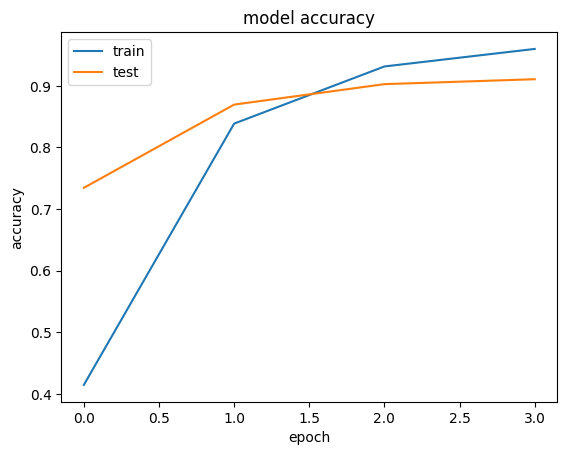

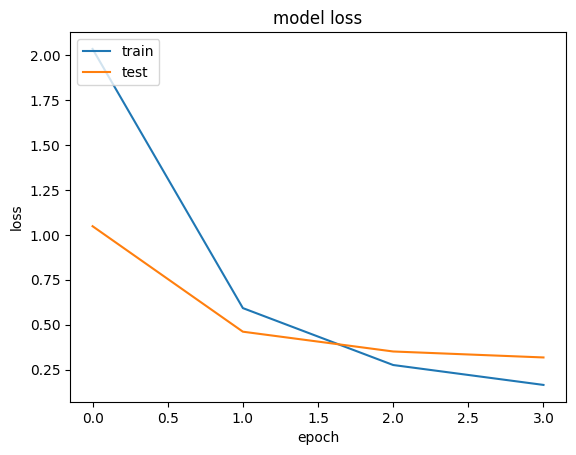

In [11]:
# Generate training plots
print("Generating training plots")
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save plot
plotfolder = str(f"/content/Plots/")
if not os.path.exists(str(f"{plotfolder}/{language}")):
    os.makedirs(str(f"{plotfolder}/{language}"))
plt.savefig(str(f"{plotfolder}/{language}/Plot_accuracy.png"))

# Clear figure
plt.close()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save plot
plt.savefig(str(f"{plotfolder}/{language}/Plot_loss.png"))

# Clear figure
plt.close()

# 2. EVALUATE A MODEL

**(Requirements) Setup the training module:**

First of all, you must configure the variables in the following cell to execute the program. Then, you can start the following cells to evaluate the model. An explanation of the different variables is provided below:

*   pos_model = POS tagger model previously trained and saved as a pickle file in `Model_outputs` folder to be evaluated
*   language = The treebank dataset to be selected
* batch_size = Number of samples that will be propagated through the network





In [12]:
# SET VARIABLES
# @title Evaluation module configuration. Set the following variables
# @markdown ### Model configuration
pos_model = "UD_English-EWT" # @param ["UD_English-EWT","UD_Russian-SynTagRus","UD_Spanish-AnCora"]
# @markdown - Note: The trained models must be saved into `/content/Model_output/{model_name}`

# @markdown ### Dataset configuration
language = "UD_English-EWT" # @param ["UD_English-EWT","UD_Russian-SynTagRus","UD_Spanish-AnCora"]

# @markdown ---
# @markdown ### Evaluation hyperparameters
batch_size = 16 # @param {type:"number", min:1, max:512, step:1}

First, we load the previously trained model using `pickle` library.

In [13]:
# Load model
print("Loading pickle model", end="")
with open(str(f"{pathfolder}{pos_model}.pickle"), "rb") as data_file:
    model = pickle.load(data_file)

print(" - DONE")

Loading pickle model - DONE


As it was explained in the previous module, we preprocess the treebank dataset. This whole process will return the data structured in two lists:
- A list consisted of input sentences
- A list of labels containing the correspondent POS tag for each word in the input sentence

Then, we evaluate the performance of the model and provide tagging accuracy metrics with its results.

In [14]:
# Preprocess test samples
print("Preprocessing test samples")
parser = Conllu_parser()
input_str = str(f"{datafolder}/{language}/test.conllu")
x_test, y_test=parser(input_str)

x_test, y_test = preprocess(x_test, y_test, model.target_label_dict)

# Evaluate
print("EVALUATING")
print("[Loss, Accuracy] =",model.evaluate((x_test, y_test), batch_size))

Preprocessing test samples
Dataset loaded in memory.
e.g. sentence number 10: TokenList<I, doubt, the, very, few, who, actually, read, my, blog, have, not, come, across, this, yet, ,, but, I, figured, I, would, put, it, out, there, anyways, ., metadata={newdoc id: "weblog-blogspot.com_floppingaces_20041126180010_ENG_20041126_180010", sent_id: "weblog-blogspot.com_floppingaces_20041126180010_ENG_20041126_180010-0001", newpar id: "weblog-blogspot.com_floppingaces_20041126180010_ENG_20041126_180010-p0001", text: "I doubt the very few who actually read my blog have not come across this yet, but I figured I would put it out there anyways."}>
EVALUATING
130/130 [==============================] - 6s 6ms/step - loss: 0.3167 - accuracy: 0.9105
[Loss, Accuracy] = [0.3166661262512207, 0.9105364084243774]


# 3. COMPUTE PART-OF-SPEECH TAGS

**(Requirements) Setup the training module:**

First of all, you must configure the variables in the following cell to execute the program. Then, you can start the following cells to evaluate the model. An explanation of the different variables is provided below:

*   pos_model = POS tagger model previously trained and saved as a pickle file in `Model_outputs` folder to be evaluated.
*   input_sentence = Sentence to be feed to the model and from which we want to obtain the POS tags of its words.

In [15]:
# SET VARIABLES
# @title Prediction module configuration. Set the following variables
# @markdown ### Model configuration
pos_model = "UD_English-EWT" # @param ["UD_English-EWT","UD_Russian-SynTagRus","UD_Spanish-AnCora"]
# @markdown - Note: The trained models must be saved into `/content/Model_output/{model_name}`

# @markdown ---
# @markdown ### Introduce your sentence:
input_sentence = "Hello there , we are improving this model a lot" # @param {type:"string"}

First, we load the previously trained model using pickle library.

In [16]:
# Load model
print("Loading pickle model")
with open(str(f"{pathfolder}{pos_model}.pickle"), "rb") as data_file:
    model = pickle.load(data_file)

Loading pickle model


We obtain the prediction of the selected model and we generate POS tags for each word.

In [17]:
# Test prediction
print("Test prediction sentence:",input_sentence)
print("Labels predicted",model.predict([[input_sentence]]))

Test prediction sentence: Hello there , we are improving this model a lot
1/1 [==============================] - 2s 2s/step
Labels predicted ['INTJ', 'ADV', 'PUNCT', 'PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'DET', 'NOUN']


---
# EXPERIMENTATION POS TAGGING MODEL

In this section we stablish an automatic cell to train and test several arquitectures at once. With analytical purposes we chose 4 different architectures to make experiments with which are specified below:

1. Units LSTM layer: 48, Hidden Dense layers: 0, Units Dense layers: -, Optimizer: adam
2. Units LSTM layer: 300, Hidden Dense layers: 2, Units Dense layers: 200, Optimizer: adam
3. Units LSTM layer: 48, Hidden Dense layers: 0, Units Dense layers: -, Optimizer: sgd
4. Units LSTM layer: 300, Hidden Dense layers: 2, Units Dense layers: 200, Optimizer: sgd

We will train those architectures in 3 different language datasets: UD_English-EWT, UD_Russian-SynTagRus and UD_Spanish-AnCora.

The training phase will be performed using a number of epochs of 500, a batch_size of 32 and the loss function sparse_categorical_crossentropy.



In [18]:
# Set the architectures for our experiments
experiment_hyperparameters = [{
    "loss" : "sparse_categorical_crossentropy",
    "optimizer" : "adam",
    "metrics" : ["accuracy"],
    "epochs" : 500,
    "batch_size" : 32
}, {
    "loss" : "sparse_categorical_crossentropy",
    "optimizer" : "adam",
    "metrics" : ["accuracy"],
    "epochs" : 500,
    "batch_size" : 32
}, {"loss" : "sparse_categorical_crossentropy",
    "optimizer" : "sgd",
    "metrics" : ["accuracy"],
    "epochs" : 500,
    "batch_size" : 32
}, {"loss" : "sparse_categorical_crossentropy",
    "optimizer" : "sgd",
    "metrics" : ["accuracy"],
    "epochs" : 500,
    "batch_size" : 32
}]

# Set topology
experiment_topology =[{
    "lstm_units" : 48,
    "num_dense" : 0,
    "dense_units" : 0
}, {
    "lstm_units" : 300,
    "num_dense" : 2,
    "dense_units" : 200
}, {
    "lstm_units" : 48,
    "num_dense" : 0,
    "dense_units" : 0
}, {
    "lstm_units" : 300,
    "num_dense" : 2,
    "dense_units" : 200
}]

In [19]:
# Train the 4 architectures in datasets "UD_English-EWT", "UD_Russian-SynTagRus", "UD_Spanish-AnCora"
for language in ["UD_English-EWT", "UD_Russian-SynTagRus", "UD_Spanish-AnCora"]:
  num_architecture = 1

  # PREPROCESS INPUT SAMPLES
  print("Loading",language,"dataset")
  print("Training architecture number",num_architecture)

  parser = Conllu_parser()

  # Parse train file
  input_str = str(f"{datafolder}/{language}/train.conllu")
  x_train, y_train = parser(input_str)

  # Parse validation file
  input_str = str(f"{datafolder}/{language}/dev.conllu")
  x_val, y_val=parser(input_str)

  # Parse test file
  input_str = str(f"{datafolder}/{language}/test.conllu")
  x_test, y_test=parser(input_str)

  # Generate a label dict
  print("Generating label dict", end="")
  target_label_dict = generate_label_dict(y_train)
  print(" - DONE")

  # Preprocess datasets
  print("Preprocessing data", end="")
  x_train, y_train = preprocess(x_train, y_train, target_label_dict)
  x_val, y_val = preprocess(x_val, y_val, target_label_dict)
  x_test, y_test = preprocess(x_test, y_test, target_label_dict)
  print(" - DONE")

  for hyperparameters, topology in zip(experiment_hyperparameters, experiment_topology):

    # Create POS model architecture
    print("Creating model")
    model = PosModel(target_label_dict)
    model.build_model(x_train, topology)

    # Train
    print("TRAINING")
    history = model.train((x_train,y_train),(x_val,y_val),hyperparameters)

    # Evaluate
    print("EVALUATING")
    print("[Eval_Loss, Eval_Accuracy] =",model.evaluate((x_test, y_test), hyperparameters["batch_size"]))
    print("DONE")

    # Save model as a pickle file
    # Create model output directory
    pathfolder = str(f"/content/Model_output/")
    if not os.path.exists(pathfolder):
      os.makedirs(pathfolder)

    print("Saving model as a pickle file", end="")
    with open(str(f"{pathfolder}{language}_{num_architecture}.pickle"), "wb") as data_file:
      pickle.dump(model,data_file)

    print(" - DONE")

    # Generate training plots
    print("Generating training plots")
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.show()

    # Save plot
    plotfolder = str(f"/content/Plots/")
    if not os.path.exists(str(f"{plotfolder}/{language}")):
        os.makedirs(str(f"{plotfolder}/{language}"))
    plt.savefig(str(f"{plotfolder}/{language}/Plot_accuracy_{num_architecture}.png"))

    # Clear figure
    plt.close()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.show()

    # Save plot
    plt.savefig(str(f"{plotfolder}/{language}/Plot_loss_{num_architecture}.png"))

    # Clear figure
    plt.close()

    num_architecture += 1

Loading UD_English-EWT dataset
Training architecture number 1
Dataset loaded in memory.
e.g. sentence number 10: TokenList<Al, -, Zaman, :, Guerrillas, killed, a, member, of, the, Kurdistan, Democratic, Party, after, kidnapping, him, in, Mosul, ., metadata={sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0011", text: "Al-Zaman : Guerrillas killed a member of the Kurdistan Democratic Party after kidnapping him in Mosul."}>
Dataset loaded in memory.
e.g. sentence number 10: TokenList<In, the, eastern, city, of, Baqubah, ,, guerrillas, detonated, a, car, bomb, outside, a, police, station, ,, killing, several, people, ., metadata={newdoc id: "weblog-juancole.com_juancole_20040114085100_ENG_20040114_085100", sent_id: "weblog-juancole.com_juancole_20040114085100_ENG_20040114_085100-0001", newpar id: "weblog-juancole.com_juancole_20040114085100_ENG_20040114_085100-p0001", text: "In the eastern city of Baqubah, guerrillas detonated a car bomb outside a police station,

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/500
392/392 [==============================] - 51s 108ms/step - loss: 1.4234 - accuracy: 0.5899 - val_loss: 0.5816 - val_accuracy: 0.8248
Epoch 2/500
392/392 [==============================] - 7s 17ms/step - loss: 0.3459 - accuracy: 0.9046 - val_loss: 0.3469 - val_accuracy: 0.9045
Epoch 3/500
392/392 [==============================] - 8s 20ms/step - loss: 0.1671 - accuracy: 0.9574 - val_loss: 0.3056 - val_accuracy: 0.9126
Epoch 4/500
392/392 [==============================] - 7s 18ms/step - loss: 0.1077 - accuracy: 0.9712 - val_loss: 0.2988 - val_accuracy: 0.9136
Epoch 5/500
392/392 [==============================] - 7s 18ms/step - loss: 0.0801 - accuracy: 0.9784 - val_loss: 0.3027 - val_accuracy: 0.9137
Epoch 5: early stopping
EVALUATING
65/65 [==============================] - 3s 52ms/step - loss: 0.3049 - accuracy: 0.9124
[Eval_Loss, Eval_Accuracy] = [0.3048722743988037, 0.9124491810798645]
DONE
Saving model as a pickle file - DONE
Generating training plots
Creating model
Mo

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/500
392/392 [==============================] - 58s 126ms/step - loss: 0.7323 - accuracy: 0.7592 - val_loss: 0.3302 - val_accuracy: 0.8971
Epoch 2/500
392/392 [==============================] - 8s 21ms/step - loss: 0.1691 - accuracy: 0.9502 - val_loss: 0.2918 - val_accuracy: 0.9141
Epoch 3/500
392/392 [==============================] - 9s 22ms/step - loss: 0.0905 - accuracy: 0.9730 - val_loss: 0.3092 - val_accuracy: 0.9146
Epoch 3: early stopping
EVALUATING
65/65 [==============================] - 0s 7ms/step - loss: 0.3143 - accuracy: 0.9124
[Eval_Loss, Eval_Accuracy] = [0.31428441405296326, 0.9124491810798645]
DONE
Saving model as a pickle file - DONE
Generating training plots
Creating model
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vec

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/500
392/392 [==============================] - 38s 76ms/step - loss: 2.7488 - accuracy: 0.1677 - val_loss: 2.6555 - val_accuracy: 0.1676
Epoch 2/500
392/392 [==============================] - 8s 21ms/step - loss: 2.5971 - accuracy: 0.1703 - val_loss: 2.5683 - val_accuracy: 0.1676
Epoch 3/500
392/392 [==============================] - 7s 17ms/step - loss: 2.5408 - accuracy: 0.1975 - val_loss: 2.5279 - val_accuracy: 0.2082
Epoch 4/500
392/392 [==============================] - 8s 21ms/step - loss: 2.5123 - accuracy: 0.2023 - val_loss: 2.5028 - val_accuracy: 0.2061
Epoch 5/500
392/392 [==============================] - 6s 17ms/step - loss: 2.4935 - accuracy: 0.2006 - val_loss: 2.4850 - val_accuracy: 0.2175
Epoch 6/500
392/392 [==============================] - 8s 21ms/step - loss: 2.4799 - accuracy: 0.2068 - val_loss: 2.4718 - val_accuracy: 0.2177
Epoch 7/500
392/392 [==============================] - 6s 16ms/step - loss: 2.4698 - accuracy: 0.2081 - val_loss: 2.4619 - val_accuracy

KeyboardInterrupt: ignored